## Analisi di Visibilità

In [134]:
# Voglio portare avanti un'analisi del campo ProductVisibility per capire come e se la visibilità influenza le vendite
# L’analisi assume che i prodotti competano per la visibilità esclusivamente all’interno dello stesso punto vendita
# ProductVisibility = quota di esposizione di un prodotto relativa all’assortimento dell’outlet in cui è venduto 

In [135]:
# faccio la somma della visibilità di tutti i prodotti per Outlet
Total_Visibility_outlet=df.groupby("OutletID")["ProductVisibility"].sum()
Total_Visibility_outlet

OutletID
OUT010    56.308832
OUT013    55.879859
OUT017    56.834646
OUT018    56.621454
OUT019    57.257041
OUT027    54.804764
OUT035    56.974873
OUT045    56.180780
OUT046    56.231875
OUT049    56.549156
Name: ProductVisibility, dtype: float64

In [136]:
# Tutti gli outlet hanno una “massa di visibilità” simile
# Le differenze sono compatibili con il numero di righe con ProductVisibility=0 (526 righe)
# La somma della ProductVisibility risulta altamente consistente tra outlet, suggerendo che la metrica sia già espressa 
# in forma relativa. Pertanto, l’analisi viene condotta sui valori originali senza ulteriore normalizzazione

In [137]:
# Focalizzo l'analisi sul cluster: OutletType = "Supermarket Type1" con PriceBand ∈ {Low, Mid-Low}
# Questo per massimizzare la probabilità che la visibilità sia una leva reale (prodotti ad acquisto frequente)
# e non sovrastata da prezzo o tipo di store
# filtro cluster omogeneo
visibility_cluster = df[(df['OutletType'] == 'Supermarket Type1') &(df['PriceBand'].isin(['Low', 'Mid-Low']))].copy()

visibility_cluster.shape

(2769, 16)

### Per l'intero Cluster scelto

In [138]:
# per valutare la performance, utilizziamo le due variabili OutlesSales e EUS
visibility_cluster[['ProductVisibility', 'OutletSales', 'EstimatedUnitsSold']].describe()

,ProductVisibility,OutletSales,EstimatedUnitsSold
count,2769.000000,2769.000000,2769.000000
mean,0.060460,1430.219975,16.169205
std,0.044459,847.990564,7.224799
min,0.000000,73.240000,1.950000
25%,0.026580,769.000000,11.000000
50%,0.048718,1270.350000,15.280000
75%,0.088178,1937.480000,20.750000
max,0.186236,6381.690000,45.290000


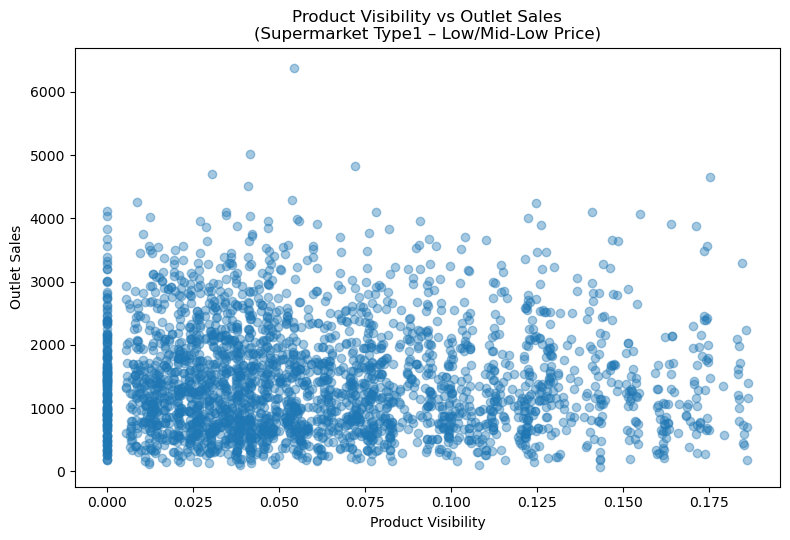

In [139]:
# grafico a dispersione ProductVisibility vs OutletSales
plt.figure(figsize=(8, 5.5))

plt.scatter(
    visibility_cluster['ProductVisibility'],
    visibility_cluster['OutletSales'],
    alpha=0.4)

plt.xlabel('Product Visibility')
plt.ylabel('Outlet Sales')
plt.title('Product Visibility vs Outlet Sales\n(Supermarket Type1 – Low/Mid-Low Price)')

plt.tight_layout()
plt.show()

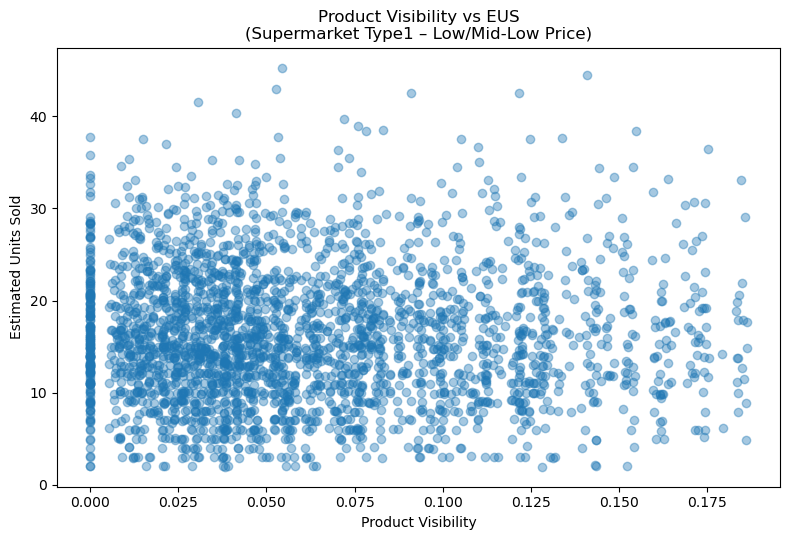

In [140]:
# grafico a dispersione ProductVisibility vs EUS
plt.figure(figsize=(8, 5.5))

plt.scatter(
    visibility_cluster['ProductVisibility'],
    visibility_cluster['EstimatedUnitsSold'],
    alpha=0.4)

plt.xlabel('Product Visibility')
plt.ylabel('Estimated Units Sold')
plt.title('Product Visibility vs EUS\n(Supermarket Type1 – Low/Mid-Low Price)')

plt.tight_layout()
plt.show()

In [141]:
# Il grafico mostra che l'effetto della visibilità non è lineare: l’aumento non sembra produrre benefici significativi
# Dividiamo i dati in 5 bucket (Visibilità=0 e i quattro quartili) per vedere se ci sono variazioni nella media delle vendite
# al passaggio tra i vari bucket

In [142]:
# separo visibility = 0
visibility_zero = visibility_cluster[visibility_cluster['ProductVisibility'] == 0].copy()

visibility_positive = visibility_cluster[visibility_cluster['ProductVisibility'] > 0].copy()

visibility_zero['VisibilityBucket'] = 'Zero Visibility'

In [143]:
# creo quartili di ProductVisibility (>0)
visibility_positive['VisibilityBucket'] = pd.qcut(
    visibility_positive['ProductVisibility'],q=4,labels=['Q1 Low', 'Q2 Mid-Low', 'Q3 Mid-High', 'Q4 High'])

In [144]:
# ricompongo il dataset
visibility_bucketed = pd.concat([visibility_zero, visibility_positive],axis=0)

In [145]:
# confronto tra i 5 bucket
visibility_summary = (visibility_bucketed.groupby('VisibilityBucket').agg(
        Avg_UnitsSold=('EstimatedUnitsSold', 'mean'),
        Avg_Sales=('OutletSales', 'mean'),
        Num_Obs=('ProductVisibility', 'count')).reset_index())

In [146]:
bucket_order = ['Zero Visibility','Q1 Low','Q2 Mid-Low','Q3 Mid-High','Q4 High']

visibility_summary['VisibilityBucket'] = pd.Categorical(visibility_summary['VisibilityBucket'],categories=bucket_order,ordered=True)

visibility_summary = visibility_summary.sort_values('VisibilityBucket')
visibility_summary

,VisibilityBucket,Avg_UnitsSold,Avg_Sales,Num_Obs
4,Zero Visibility,16.711034,1488.943161,174
0,Q1 Low,16.351464,1446.118706,649
1,Q2 Mid-Low,16.034823,1473.397904,649
2,Q3 Mid-High,16.087454,1397.524660,648
3,Q4 High,16.057689,1388.044284,649


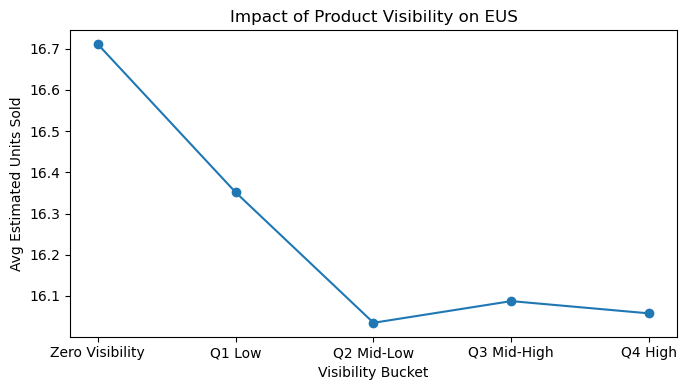

In [147]:
# grafico Product Visibility on EUS
plt.figure(figsize=(7, 4))

plt.plot(
    visibility_summary['VisibilityBucket'],
    visibility_summary['Avg_UnitsSold'],
    marker='o')

plt.xlabel('Visibility Bucket')
plt.ylabel('Avg Estimated Units Sold')
plt.title('Impact of Product Visibility on EUS')

plt.tight_layout()
plt.show()

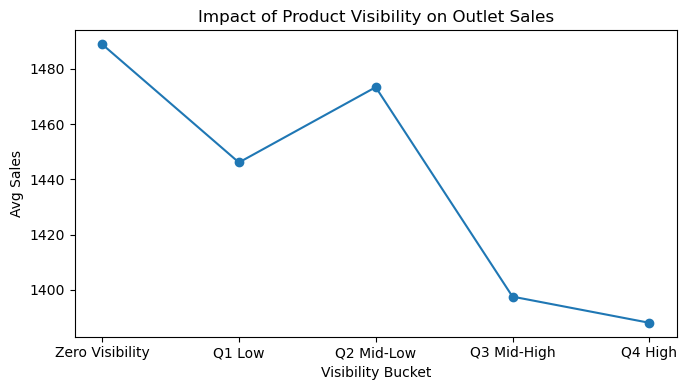

In [148]:
# grafico Product Visibility on Outlet Sales
plt.figure(figsize=(7, 4))

plt.plot(
    visibility_summary['VisibilityBucket'],
    visibility_summary['Avg_Sales'],
    marker='o')

plt.xlabel('Visibility Bucket')
plt.ylabel('Avg Sales')
plt.title('Impact of Product Visibility on Outlet Sales')

plt.tight_layout()
plt.show()

In [149]:
# Nel cluster analizzato (Supermarket Type1, Low/Mid-Low price), la ProductVisibility non mostra un impatto positivo 
# significativo né sulle unità vendute né sul fatturato medio => la visibilità NON è il driver principale della vendita

### Per ProductType del Cluster

In [150]:
# Seleziono tre categorie del Cluster per verificare se la visibilità impatta le vendite almeno in quell'ambito
target_categories = ['Fruits and Vegetables','Snack Foods','Soft Drinks']

In [151]:
# procedo con gli stessi step fatti per l'analisi sull'intero Cluster
def visibility_bucket_analysis(df_cat):

    # separo visibility = 0 e > 0
    vis_zero = df_cat[df_cat['ProductVisibility'] == 0].copy()
    vis_pos = df_cat[df_cat['ProductVisibility'] > 0].copy()

    # bucket quartili sui valori > 0
    vis_pos['VisibilityBucket'] = pd.qcut(vis_pos['ProductVisibility'],
        q=4,labels=['Q1 Low', 'Q2 Mid-Low', 'Q3 Mid-High', 'Q4 High'])

    vis_zero['VisibilityBucket'] = 'Zero Visibility'

    df_bucketed = pd.concat([vis_zero, vis_pos])

    # tabella di sintesi
    summary = (df_bucketed.groupby('VisibilityBucket').agg(
            Avg_UnitsSold=('EstimatedUnitsSold', 'mean'),
            Avg_Sales=('OutletSales', 'mean'),
            Num_Obs=('ProductVisibility', 'count')).reset_index())

    # ordinamento logico
    bucket_order = ['Zero Visibility','Q1 Low','Q2 Mid-Low','Q3 Mid-High','Q4 High']

    summary['VisibilityBucket'] = pd.Categorical(summary['VisibilityBucket'],categories=bucket_order,ordered=True)

    return summary.sort_values('VisibilityBucket')

In [152]:
visibility_results_by_category = {}

for category in target_categories:
    df_cat = visibility_cluster[visibility_cluster['ProductType'] == category].copy()

    visibility_results_by_category[category] = visibility_bucket_analysis(df_cat)

In [153]:
# tabella visibilità per ProductType 'Fruits and Vegetables'
visibility_results_by_category['Fruits and Vegetables']

,VisibilityBucket,Avg_UnitsSold,Avg_Sales,Num_Obs
4,Zero Visibility,18.794091,1837.819545,22
0,Q1 Low,16.108202,1376.051461,89
1,Q2 Mid-Low,16.436023,1549.036818,88
2,Q3 Mid-High,15.804432,1497.959432,88
3,Q4 High,15.505568,1332.734432,88


In [154]:
# Per Fruits and Vegetables la visibilità sembra non aggiungere valore (categoria ad acquisto routinario, Visibility-Neutral)
# => ottimizzare spazio, non aumentare esposizione

In [155]:
# tabella visibilità per ProductType 'Snack Foods'
visibility_results_by_category['Snack Foods']

,VisibilityBucket,Avg_UnitsSold,Avg_Sales,Num_Obs
4,Zero Visibility,18.880455,1651.092727,22
0,Q1 Low,17.211685,1625.218202,89
1,Q2 Mid-Low,16.468989,1643.575506,89
2,Q3 Mid-High,16.136023,1480.595682,88
3,Q4 High,15.184045,1507.168989,89


In [156]:
# Per Snack Foods la visibilità sembra non aggiungere valore, anzi se si guarda a EUS c'è una relazione inversa (Visibility-Resistant)
# => ridurre spazio dedicato tramite esposizioni temporanee e/o razionalizzazione dell'assortimento

In [157]:
# tabella visibilità per ProductType 'Soft Drinks'
visibility_results_by_category['Soft Drinks']

,VisibilityBucket,Avg_UnitsSold,Avg_Sales,Num_Obs
4,Zero Visibility,14.336154,1370.525385,13
0,Q1 Low,16.930294,1304.204412,34
1,Q2 Mid-Low,17.727941,1054.099412,34
2,Q3 Mid-High,15.249091,1281.281212,33
3,Q4 High,17.818529,1339.921471,34


In [158]:
# Per Soft Drinks la visibilità sembra essere una leva reale anche se non lineare (categoria fortemente impulsiva, Visibility-Driven)
# => categoria prioritaria per esposizione

In [159]:
# Da queste analisi abbiamo visto che la visibilità non sembra essere un driver principale alla vendita, ma varia tra
# le categorie: può risultare inefficiente (vedi ProductType "Snack Foods") o può apportare valore (vedi ProductType "Soft Drinks")

In [160]:
# Reputo soddisfacente le analisi fatte e procedo alla definizione dei KPI